In [1]:
import sys, os

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from yolo import YOLO
#keras-yolo에서 image처리를 주요 PIL로 수행. 
from PIL import Image
from keras.models import load_model
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
'''
(1) 개 탐지 YOLO 모델
(2) 개 얼굴 탐지 YOLO 모델
(3) 개 품종 분류 CNN 모델
(4) 입마개 착용 여부 분류 CNN 모델
'''

dog_yolo = YOLO(model_path='/home/dsl001/캡스톤 디자인/Dog detector.h5',
                anchors_path='~/캡스톤 디자인/keras-yolo3/model_data/yolo_anchors.txt',
                classes_path='~/캡스톤 디자인/keras-yolo3/model_data/Dog_classes.txt')

dog_face_yolo = YOLO(model_path='/home/dsl001/캡스톤 디자인/Dog detector.h5',
                     anchors_path='~/캡스톤 디자인/keras-yolo3/model_data/yolo_anchors.txt',
                     classes_path='~/캡스톤 디자인/keras-yolo3/model_data/Dog_classes.txt')

dog_breed_cnn = load_model('./dog breed classifier.h5')

dog_muzzle_cnn = load_model('./dog muzzle classifier.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
/home/dsl001/캡스톤 디자인/Dog detector.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/dsl001/캡스톤 디자인/Dog detector.h5 model, anchors, and classes loaded.





In [3]:
# 개 품종과 입마개 착용 여부 레이블.

breed_label = pd.read_csv('encoding_label.csv').drop('Unnamed: 0', axis=1)
muzzle_label = pd.DataFrame({'Muzzle' : ['Yes', 'No']})

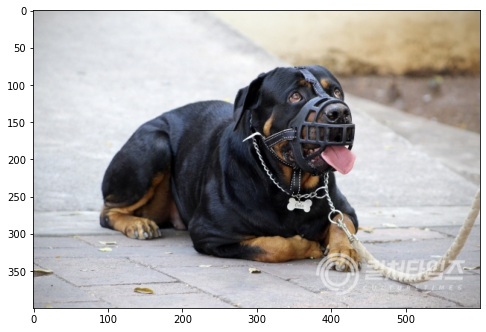

In [52]:
img = Image.open('/home/dsl001/캡스톤 디자인/5.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)

In [5]:
# 개 품종 분류와 입마개 착용 여부 분류를 위해 이미지 크기 변환

def transfer_image(img):
    resize = img.resize((224, 224))
    resize = np.array(resize)/255.
    resize = resize.reshape(1, 224, 224, 3)
    return resize

In [6]:
# 개 품종 레이블 반환

def get_pred_breed_label(pred_prob):
    return breed_label.iloc[np.argmax(pred_prob)]['breed']

In [7]:
# 입마개 착용 여부 레이블 반환

def get_pred_muzzle_label(pred_prob):
    if pred_prob > 0.5:
        return 'Without muzzle'
    else:
        return 'With Muzzle'

In [8]:
# 개 품종 분류 결과 시각화

def plot_pred(pred_prob, pred_label, img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
    plt.title("{} {:2.0f}%".format(pred_label, np.max(pred_prob)*100))

def dog_plot_pred_conf(pred_prob, pred_label):
    top_10_pred_indexes = pred_prob.argsort()[0, -10:][::-1] # argsort 작은값부터 순서대로
    top_10_pred_values = pred_prob[0, top_10_pred_indexes]
    top_10_pred_labels = breed_label.iloc[top_10_pred_indexes]['breed']
    
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                       top_10_pred_values, 
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_label)].set_color("green")

In [9]:
# 입마개 착용 여부 분류 결과 시각화
        
def muzzle_plot_pred_conf(pred_prob, pred_label):
    pred_indexes = ['With muzzle', 'Without muzzle']
    pred_values = [1-float(pred_prob.reshape(-1)), float(pred_prob.reshape(-1))]
    pred_labels = 2
    
    top_plot = plt.bar(np.arange(pred_labels), 
                       pred_values, 
                       color="grey")
    plt.xticks(np.arange(pred_labels),
               labels=pred_indexes,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_values)].set_color("green")

In [53]:
# 개 이미지에서 개 얼굴을 제대로 탐지하지 못할 경우 예외처리가 필요

def detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, img):
    green_color = (0, 255, 0)
    blue_color = (255, 0, 0)
    
    dog_image, dog_info = dog_yolo.detect_image(img)
    dog_image_array = np.array(dog_image)
    dog_row = dog_image_array.shape[0]
    dog_col = dog_image_array.shape[1]

    tmp = []
    for data in dog_info:
        label = data[0]
        dog_left_top = data[1]
        dog_right_bottom = data[2]

        dog_obj = Image.fromarray(dog_image_array[dog_left_top[1]:dog_right_bottom[1]+1, dog_left_top[0]:dog_right_bottom[0]+1, :])
        dog_resize = transfer_image(dog_obj)

        breed_pred_prob = dog_breed_cnn.predict(dog_resize)
        breed_pred_label = get_pred_breed_label(breed_pred_prob)
        
        plt.subplot(1, 2, 1)
        plot_pred(breed_pred_prob, breed_pred_label, dog_obj)
        plt.subplot(1, 2, 2)
        dog_plot_pred_conf(breed_pred_prob, breed_pred_label)
        plt.savefig('/home/dsl001/캡스톤 디자인/Dog image/dog.jpg')
        plt.close()
    
        # 조건문을 이용하여 탐지된 개가 맹견일 경우, 개 얼굴 탐지와 입마개 착용 분류를 진행

        dog_face_image, dog_face_info = dog_face_yolo.detect_image(dog_obj)
        dog_face_image_array = np.array(dog_face_image)

        for data in dog_face_info:
            label = data[0]
            muzzle_left_top = data[1]
            muzzle_right_bottom = data[2]

            dog_face_obj = Image.fromarray(dog_face_image_array[muzzle_left_top[1]:muzzle_right_bottom[1]+1, muzzle_left_top[0]:muzzle_right_bottom[0]+1, :])
            dog_face_resize = transfer_image(dog_face_obj)

            muzzle_pred_prob = dog_muzzle_cnn.predict(dog_face_resize)
            muzzle_pred_label = get_pred_muzzle_label(muzzle_pred_prob)
            
            plt.subplot(1, 2, 1)
            plot_pred(muzzle_pred_prob, muzzle_pred_label, dog_face_obj)
            plt.subplot(1, 2, 2)
            muzzle_plot_pred_conf(muzzle_pred_prob, muzzle_pred_label)
            plt.savefig('/home/dsl001/캡스톤 디자인/Dog image/dog.jpg')
            plt.close()
    
            tmp_left_top = ((dog_left_top[0] + muzzle_left_top[0]), (dog_left_top[1] + muzzle_left_top[1]))
            tmp_right_bottom = ((dog_left_top[0] + muzzle_right_bottom[0]), (dog_left_top[1] + muzzle_right_bottom[1]))
            tmp.append((muzzle_pred_label, muzzle_pred_prob, tmp_left_top, tmp_right_bottom))

    numpy_img = np.array(dog_image)
    opencv_img = cv2.cvtColor(numpy_img, cv2.COLOR_BGR2RGB)
    
    for info in tmp:
        label = info[0]
        prob = info[1]
        left_top = info[2]
        right_bottom = info[3]
        caption = '{} : {:.4f}'.format(label, prob.reshape(-1)[0])

        if label == 'Without muzzle':
            opencv_img = cv2.rectangle(opencv_img, left_top, right_bottom, green_color, 2)
            opencv_img = cv2.putText(opencv_img, caption, (left_top[0], left_top[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, green_color, 2)
        else:
            opencv_img = cv2.rectangle(opencv_img, left_top, right_bottom, blue_color, 2)
            opencv_img = cv2.putText(opencv_img, caption, (left_top[0], left_top[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, blue_color, 2)

    color_coverted = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_coverted)
#     plt.imshow(pil_image)
    
    
    return pil_image

In [54]:
detected_image = detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, img)

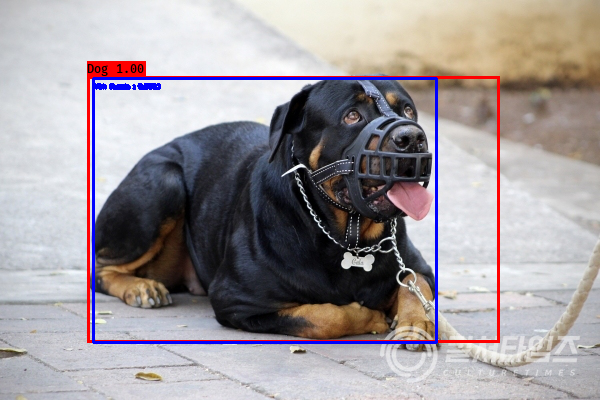

In [55]:
detected_image

In [56]:
import time

def detect_video(input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
#     codec = cv2.VideoWriter_fourcc(*'DIVX')
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, '원본 영상 FPS:',vid_fps, '원본 Frame 크기:', vid_size)
    index = 0
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break
        start = time.time()
        # PIL Package를 내부에서 사용하므로 cv2에서 읽은 image_frame array를 다시 PIL의 Image형태로 변환해야 함.  
        image = Image.fromarray(image_frame)
        # 아래는 인자로 입력된 yolo객체의 detect_image()로 변환한다.
        detected_image  = detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, image)
        # cv2의 video writer로 출력하기 위해 다시 PIL의 Image형태를 array형태로 변환 
        result = np.asarray(detected_image)
        index +=1
        print('#### frame:{0} 이미지 처리시간:{1}'.format(index, round(time.time()-start,3)))
        vid_writer.write(result)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [57]:
detect_video('/home/dsl001/캡스톤 디자인/산책1.mp4', '/home/dsl001/캡스톤 디자인/산책1.avi')

총 Frame 갯수: 12447 원본 영상 FPS: 30.0 원본 Frame 크기: (1280, 720)
#### frame:1 이미지 처리시간:0.276
#### frame:2 이미지 처리시간:0.25
#### frame:3 이미지 처리시간:0.255
#### frame:4 이미지 처리시간:0.27
#### frame:5 이미지 처리시간:0.25
#### frame:6 이미지 처리시간:0.253
#### frame:7 이미지 처리시간:0.242
#### frame:8 이미지 처리시간:0.245
#### frame:9 이미지 처리시간:0.25
#### frame:10 이미지 처리시간:0.644
#### frame:11 이미지 처리시간:0.467
#### frame:12 이미지 처리시간:0.275
#### frame:13 이미지 처리시간:0.256
#### frame:14 이미지 처리시간:0.317
#### frame:15 이미지 처리시간:0.286
#### frame:16 이미지 처리시간:0.309
#### frame:17 이미지 처리시간:0.3
#### frame:18 이미지 처리시간:0.303
#### frame:19 이미지 처리시간:0.281
#### frame:20 이미지 처리시간:0.305
#### frame:21 이미지 처리시간:0.285
#### frame:22 이미지 처리시간:0.256
#### frame:23 이미지 처리시간:0.232
#### frame:24 이미지 처리시간:0.249
#### frame:25 이미지 처리시간:0.259
#### frame:26 이미지 처리시간:0.258
#### frame:27 이미지 처리시간:0.276
#### frame:28 이미지 처리시간:0.243
#### frame:29 이미지 처리시간:0.236
#### frame:30 이미지 처리시간:0.267
#### frame:31 이미지 처리시간:0.247
#### frame:32 이미지 처리시간:0.24
#### frame:33 이미지 처리시간:0.234


#### frame:277 이미지 처리시간:0.87
#### frame:278 이미지 처리시간:0.881
#### frame:279 이미지 처리시간:0.883
#### frame:280 이미지 처리시간:0.899
#### frame:281 이미지 처리시간:2.336
#### frame:282 이미지 처리시간:0.983
#### frame:283 이미지 처리시간:0.917
#### frame:284 이미지 처리시간:0.917
#### frame:285 이미지 처리시간:0.905
#### frame:286 이미지 처리시간:0.881
#### frame:287 이미지 처리시간:0.853
#### frame:288 이미지 처리시간:0.852
#### frame:289 이미지 처리시간:0.879
#### frame:290 이미지 처리시간:0.89
#### frame:291 이미지 처리시간:2.384
#### frame:292 이미지 처리시간:1.004
#### frame:293 이미지 처리시간:0.96
#### frame:294 이미지 처리시간:0.925
#### frame:295 이미지 처리시간:0.894
#### frame:296 이미지 처리시간:0.855
#### frame:297 이미지 처리시간:0.895
#### frame:298 이미지 처리시간:0.884
#### frame:299 이미지 처리시간:0.934
#### frame:300 이미지 처리시간:0.92
#### frame:301 이미지 처리시간:1.048
#### frame:302 이미지 처리시간:2.503
#### frame:303 이미지 처리시간:0.937
#### frame:304 이미지 처리시간:1.083
#### frame:305 이미지 처리시간:0.842
#### frame:306 이미지 처리시간:0.861
#### frame:307 이미지 처리시간:0.864
#### frame:308 이미지 처리시간:0.859
#### frame:309 이미지 처리시간:0.883
#### frame:310

#### frame:552 이미지 처리시간:0.872
#### frame:553 이미지 처리시간:0.877
#### frame:554 이미지 처리시간:0.868
#### frame:555 이미지 처리시간:0.844
#### frame:556 이미지 처리시간:0.824
#### frame:557 이미지 처리시간:0.843
#### frame:558 이미지 처리시간:2.179
#### frame:559 이미지 처리시간:0.904
#### frame:560 이미지 처리시간:1.001
#### frame:561 이미지 처리시간:0.873
#### frame:562 이미지 처리시간:0.863
#### frame:563 이미지 처리시간:0.847
#### frame:564 이미지 처리시간:0.857
#### frame:565 이미지 처리시간:0.827
#### frame:566 이미지 처리시간:0.825
#### frame:567 이미지 처리시간:0.825
#### frame:568 이미지 처리시간:0.843
#### frame:569 이미지 처리시간:2.194
#### frame:570 이미지 처리시간:0.916
#### frame:571 이미지 처리시간:0.922
#### frame:572 이미지 처리시간:0.902
#### frame:573 이미지 처리시간:0.861
#### frame:574 이미지 처리시간:0.871
#### frame:575 이미지 처리시간:0.841
#### frame:576 이미지 처리시간:0.823
#### frame:577 이미지 처리시간:0.823
#### frame:578 이미지 처리시간:0.87
#### frame:579 이미지 처리시간:2.244
#### frame:580 이미지 처리시간:0.972
#### frame:581 이미지 처리시간:0.924
#### frame:582 이미지 처리시간:0.878
#### frame:583 이미지 처리시간:0.901
#### frame:584 이미지 처리시간:0.991
#### frame:

#### frame:827 이미지 처리시간:0.9
#### frame:828 이미지 처리시간:0.849
#### frame:829 이미지 처리시간:0.853
#### frame:830 이미지 처리시간:0.807
#### frame:831 이미지 처리시간:0.841
#### frame:832 이미지 처리시간:0.91
#### frame:833 이미지 처리시간:0.832
#### frame:834 이미지 처리시간:2.146
#### frame:835 이미지 처리시간:0.916
#### frame:836 이미지 처리시간:0.977
#### frame:837 이미지 처리시간:0.923
#### frame:838 이미지 처리시간:0.86
#### frame:839 이미지 처리시간:0.883
#### frame:840 이미지 처리시간:0.889
#### frame:841 이미지 처리시간:0.831
#### frame:842 이미지 처리시간:0.849
#### frame:843 이미지 처리시간:0.824
#### frame:844 이미지 처리시간:2.233
#### frame:845 이미지 처리시간:1.043
#### frame:846 이미지 처리시간:0.968
#### frame:847 이미지 처리시간:0.869
#### frame:848 이미지 처리시간:0.859
#### frame:849 이미지 처리시간:0.856
#### frame:850 이미지 처리시간:0.851
#### frame:851 이미지 처리시간:0.872
#### frame:852 이미지 처리시간:0.846
#### frame:853 이미지 처리시간:0.859
#### frame:854 이미지 처리시간:2.247
#### frame:855 이미지 처리시간:0.961
#### frame:856 이미지 처리시간:0.917
#### frame:857 이미지 처리시간:0.944
#### frame:858 이미지 처리시간:0.879
#### frame:859 이미지 처리시간:0.858
#### frame:860

#### frame:1099 이미지 처리시간:2.188
#### frame:1100 이미지 처리시간:0.93
#### frame:1101 이미지 처리시간:0.891
#### frame:1102 이미지 처리시간:0.896
#### frame:1103 이미지 처리시간:0.816
#### frame:1104 이미지 처리시간:0.862
#### frame:1105 이미지 처리시간:0.826
#### frame:1106 이미지 처리시간:0.818
#### frame:1107 이미지 처리시간:0.831
#### frame:1108 이미지 처리시간:0.84
#### frame:1109 이미지 처리시간:2.286
#### frame:1110 이미지 처리시간:0.969
#### frame:1111 이미지 처리시간:0.908
#### frame:1112 이미지 처리시간:0.82
#### frame:1113 이미지 처리시간:0.837
#### frame:1114 이미지 처리시간:0.845
#### frame:1115 이미지 처리시간:0.801
#### frame:1116 이미지 처리시간:0.827
#### frame:1117 이미지 처리시간:0.84
#### frame:1118 이미지 처리시간:1.505
#### frame:1119 이미지 처리시간:1.578
#### frame:1120 이미지 처리시간:0.891
#### frame:1121 이미지 처리시간:0.881
#### frame:1122 이미지 처리시간:0.85
#### frame:1123 이미지 처리시간:0.811
#### frame:1124 이미지 처리시간:0.858
#### frame:1125 이미지 처리시간:0.804
#### frame:1126 이미지 처리시간:0.821
#### frame:1127 이미지 처리시간:0.842
#### frame:1128 이미지 처리시간:0.869
#### frame:1129 이미지 처리시간:2.106
#### frame:1130 이미지 처리시간:0.951
#### frame:11

#### frame:1365 이미지 처리시간:0.932
#### frame:1366 이미지 처리시간:0.895
#### frame:1367 이미지 처리시간:0.894
#### frame:1368 이미지 처리시간:0.848
#### frame:1369 이미지 처리시간:0.913
#### frame:1370 이미지 처리시간:0.92
#### frame:1371 이미지 처리시간:0.91
#### frame:1372 이미지 처리시간:0.891
#### frame:1373 이미지 처리시간:2.21
#### frame:1374 이미지 처리시간:1.023
#### frame:1375 이미지 처리시간:1.025
#### frame:1376 이미지 처리시간:0.887
#### frame:1377 이미지 처리시간:0.875
#### frame:1378 이미지 처리시간:0.894
#### frame:1379 이미지 처리시간:0.897
#### frame:1380 이미지 처리시간:0.892
#### frame:1381 이미지 처리시간:0.875
#### frame:1382 이미지 처리시간:2.208
#### frame:1383 이미지 처리시간:0.98
#### frame:1384 이미지 처리시간:0.952
#### frame:1385 이미지 처리시간:0.987
#### frame:1386 이미지 처리시간:0.896
#### frame:1387 이미지 처리시간:0.87
#### frame:1388 이미지 처리시간:0.841
#### frame:1389 이미지 처리시간:0.864
#### frame:1390 이미지 처리시간:0.863
#### frame:1391 이미지 처리시간:0.845
#### frame:1392 이미지 처리시간:0.824
#### frame:1393 이미지 처리시간:2.216
#### frame:1394 이미지 처리시간:0.931
#### frame:1395 이미지 처리시간:0.976
#### frame:1396 이미지 처리시간:0.836
#### frame:13

#### frame:1631 이미지 처리시간:0.918
#### frame:1632 이미지 처리시간:7.034
#### frame:1633 이미지 처리시간:1.446
#### frame:1634 이미지 처리시간:0.81
#### frame:1635 이미지 처리시간:0.874
#### frame:1636 이미지 처리시간:0.99
#### frame:1637 이미지 처리시간:0.939
#### frame:1638 이미지 처리시간:0.856
#### frame:1639 이미지 처리시간:0.811
#### frame:1640 이미지 처리시간:0.826
#### frame:1641 이미지 처리시간:0.795
#### frame:1642 이미지 처리시간:0.817
#### frame:1643 이미지 처리시간:0.817
#### frame:1644 이미지 처리시간:2.184
#### frame:1645 이미지 처리시간:0.938
#### frame:1646 이미지 처리시간:0.96
#### frame:1647 이미지 처리시간:0.813
#### frame:1648 이미지 처리시간:0.809
#### frame:1649 이미지 처리시간:0.794
#### frame:1650 이미지 처리시간:0.815
#### frame:1651 이미지 처리시간:0.829
#### frame:1652 이미지 처리시간:0.807
#### frame:1653 이미지 처리시간:2.283
#### frame:1654 이미지 처리시간:0.938
#### frame:1655 이미지 처리시간:0.932
#### frame:1656 이미지 처리시간:0.919
#### frame:1657 이미지 처리시간:0.827
#### frame:1658 이미지 처리시간:0.838
#### frame:1659 이미지 처리시간:0.832
#### frame:1660 이미지 처리시간:0.814
#### frame:1661 이미지 처리시간:0.83
#### frame:1662 이미지 처리시간:0.828
#### frame:1

#### frame:1897 이미지 처리시간:2.364
#### frame:1898 이미지 처리시간:1.04
#### frame:1899 이미지 처리시간:1.148
#### frame:1900 이미지 처리시간:0.975
#### frame:1901 이미지 처리시간:0.937
#### frame:1902 이미지 처리시간:0.963
#### frame:1903 이미지 처리시간:0.251
#### frame:1904 이미지 처리시간:0.239
#### frame:1905 이미지 처리시간:0.241
#### frame:1906 이미지 처리시간:0.238
#### frame:1907 이미지 처리시간:0.236
#### frame:1908 이미지 처리시간:0.7
#### frame:1909 이미지 처리시간:1.834
#### frame:1910 이미지 처리시간:1.168
#### frame:1911 이미지 처리시간:0.811
#### frame:1912 이미지 처리시간:0.875
#### frame:1913 이미지 처리시간:0.674
#### frame:1914 이미지 처리시간:0.864
#### frame:1915 이미지 처리시간:0.862
#### frame:1916 이미지 처리시간:0.849
#### frame:1917 이미지 처리시간:0.852
#### frame:1918 이미지 처리시간:0.818
#### frame:1919 이미지 처리시간:1.753
#### frame:1920 이미지 처리시간:1.164
#### frame:1921 이미지 처리시간:0.278
#### frame:1922 이미지 처리시간:0.97
#### frame:1923 이미지 처리시간:0.886
#### frame:1924 이미지 처리시간:0.228
#### frame:1925 이미지 처리시간:0.818
#### frame:1926 이미지 처리시간:0.83
#### frame:1927 이미지 처리시간:0.864
#### frame:1928 이미지 처리시간:0.855
#### frame:19

#### frame:2163 이미지 처리시간:0.935
#### frame:2164 이미지 처리시간:0.866
#### frame:2165 이미지 처리시간:0.823
#### frame:2166 이미지 처리시간:0.826
#### frame:2167 이미지 처리시간:0.828
#### frame:2168 이미지 처리시간:0.788
#### frame:2169 이미지 처리시간:0.803
#### frame:2170 이미지 처리시간:0.822
#### frame:2171 이미지 처리시간:0.842
#### frame:2172 이미지 처리시간:2.197
#### frame:2173 이미지 처리시간:0.871
#### frame:2174 이미지 처리시간:0.917
#### frame:2175 이미지 처리시간:0.885
#### frame:2176 이미지 처리시간:0.814
#### frame:2177 이미지 처리시간:0.811
#### frame:2178 이미지 처리시간:0.798
#### frame:2179 이미지 처리시간:0.805
#### frame:2180 이미지 처리시간:0.846
#### frame:2181 이미지 처리시간:0.817
#### frame:2182 이미지 처리시간:2.198
#### frame:2183 이미지 처리시간:0.937
#### frame:2184 이미지 처리시간:0.934
#### frame:2185 이미지 처리시간:0.869
#### frame:2186 이미지 처리시간:0.841
#### frame:2187 이미지 처리시간:0.833
#### frame:2188 이미지 처리시간:0.816
#### frame:2189 이미지 처리시간:0.818
#### frame:2190 이미지 처리시간:0.848
#### frame:2191 이미지 처리시간:0.805
#### frame:2192 이미지 처리시간:0.85
#### frame:2193 이미지 처리시간:2.2
#### frame:2194 이미지 처리시간:0.881
#### frame:

#### frame:2429 이미지 처리시간:0.925
#### frame:2430 이미지 처리시간:1.013
#### frame:2431 이미지 처리시간:0.91
#### frame:2432 이미지 처리시간:1.807
#### frame:2433 이미지 처리시간:1.696
#### frame:2434 이미지 처리시간:1.483
#### frame:2435 이미지 처리시간:1.338
#### frame:2436 이미지 처리시간:1.312
#### frame:2437 이미지 처리시간:1.46
#### frame:2438 이미지 처리시간:1.474
#### frame:2439 이미지 처리시간:1.488
#### frame:2440 이미지 처리시간:2.112
#### frame:2441 이미지 처리시간:2.239
#### frame:2442 이미지 처리시간:1.625
#### frame:2443 이미지 처리시간:1.536
#### frame:2444 이미지 처리시간:1.464
#### frame:2445 이미지 처리시간:1.487
#### frame:2446 이미지 처리시간:1.492
#### frame:2447 이미지 처리시간:1.35
#### frame:2448 이미지 처리시간:3.835
#### frame:2449 이미지 처리시간:1.042
#### frame:2450 이미지 처리시간:0.921
#### frame:2451 이미지 처리시간:0.923
#### frame:2452 이미지 처리시간:0.905
#### frame:2453 이미지 처리시간:0.921
#### frame:2454 이미지 처리시간:0.255
#### frame:2455 이미지 처리시간:0.907
#### frame:2456 이미지 처리시간:3.121
#### frame:2457 이미지 처리시간:1.078
#### frame:2458 이미지 처리시간:1.653
#### frame:2459 이미지 처리시간:0.843
#### frame:2460 이미지 처리시간:0.874
#### frame:

#### frame:2695 이미지 처리시간:0.906
#### frame:2696 이미지 처리시간:0.93
#### frame:2697 이미지 처리시간:0.911
#### frame:2698 이미지 처리시간:2.24
#### frame:2699 이미지 처리시간:1.031
#### frame:2700 이미지 처리시간:1.007
#### frame:2701 이미지 처리시간:0.997
#### frame:2702 이미지 처리시간:0.993
#### frame:2703 이미지 처리시간:0.912
#### frame:2704 이미지 처리시간:0.932
#### frame:2705 이미지 처리시간:0.9
#### frame:2706 이미지 처리시간:0.887
#### frame:2707 이미지 처리시간:0.92
#### frame:2708 이미지 처리시간:0.919
#### frame:2709 이미지 처리시간:0.939
#### frame:2710 이미지 처리시간:2.185
#### frame:2711 이미지 처리시간:1.032
#### frame:2712 이미지 처리시간:0.996
#### frame:2713 이미지 처리시간:0.997
#### frame:2714 이미지 처리시간:0.908
#### frame:2715 이미지 처리시간:0.935
#### frame:2716 이미지 처리시간:0.955
#### frame:2717 이미지 처리시간:0.928
#### frame:2718 이미지 처리시간:0.907
#### frame:2719 이미지 처리시간:0.975
#### frame:2720 이미지 처리시간:0.992
#### frame:2721 이미지 처리시간:2.193
#### frame:2722 이미지 처리시간:0.99
#### frame:2723 이미지 처리시간:0.932
#### frame:2724 이미지 처리시간:1.02
#### frame:2725 이미지 처리시간:0.945
#### frame:2726 이미지 처리시간:0.925
#### frame:2727

#### frame:2961 이미지 처리시간:0.906
#### frame:2962 이미지 처리시간:0.853
#### frame:2963 이미지 처리시간:0.839
#### frame:2964 이미지 처리시간:0.907
#### frame:2965 이미지 처리시간:0.889
#### frame:2966 이미지 처리시간:0.854
#### frame:2967 이미지 처리시간:0.843
#### frame:2968 이미지 처리시간:2.179
#### frame:2969 이미지 처리시간:0.907
#### frame:2970 이미지 처리시간:1.548
#### frame:2971 이미지 처리시간:1.462
#### frame:2972 이미지 처리시간:1.385
#### frame:2973 이미지 처리시간:1.383
#### frame:2974 이미지 처리시간:1.383
#### frame:2975 이미지 처리시간:2.059
#### frame:2976 이미지 처리시간:2.244
#### frame:2977 이미지 처리시간:1.508
#### frame:2978 이미지 처리시간:1.396
#### frame:2979 이미지 처리시간:1.415
#### frame:2980 이미지 처리시간:1.414
#### frame:2981 이미지 처리시간:2.115
#### frame:2982 이미지 처리시간:2.394
#### frame:2983 이미지 처리시간:1.585
#### frame:2984 이미지 처리시간:1.404
#### frame:2985 이미지 처리시간:1.412
#### frame:2986 이미지 처리시간:1.425
#### frame:2987 이미지 처리시간:1.445
#### frame:2988 이미지 처리시간:2.773
#### frame:2989 이미지 처리시간:1.589
#### frame:2990 이미지 처리시간:1.659
#### frame:2991 이미지 처리시간:1.469
#### frame:2992 이미지 처리시간:1.59
#### fram

#### frame:3227 이미지 처리시간:0.819
#### frame:3228 이미지 처리시간:2.175
#### frame:3229 이미지 처리시간:1.613
#### frame:3230 이미지 처리시간:1.565
#### frame:3231 이미지 처리시간:1.474
#### frame:3232 이미지 처리시간:1.402
#### frame:3233 이미지 처리시간:1.454
#### frame:3234 이미지 처리시간:1.399
#### frame:3235 이미지 처리시간:1.435
#### frame:3236 이미지 처리시간:2.149
#### frame:3237 이미지 처리시간:2.236
#### frame:3238 이미지 처리시간:1.55
#### frame:3239 이미지 처리시간:1.487
#### frame:3240 이미지 처리시간:1.454
#### frame:3241 이미지 처리시간:1.479
#### frame:3242 이미지 처리시간:1.405
#### frame:3243 이미지 처리시간:2.193
#### frame:3244 이미지 처리시간:2.227
#### frame:3245 이미지 처리시간:1.333
#### frame:3246 이미지 처리시간:1.278
#### frame:3247 이미지 처리시간:1.288
#### frame:3248 이미지 처리시간:1.395
#### frame:3249 이미지 처리시간:1.289
#### frame:3250 이미지 처리시간:2.225
#### frame:3251 이미지 처리시간:0.935
#### frame:3252 이미지 처리시간:0.885
#### frame:3253 이미지 처리시간:0.885
#### frame:3254 이미지 처리시간:0.844
#### frame:3255 이미지 처리시간:0.846
#### frame:3256 이미지 처리시간:0.827
#### frame:3257 이미지 처리시간:0.847
#### frame:3258 이미지 처리시간:0.852
#### fram

#### frame:3493 이미지 처리시간:0.83
#### frame:3494 이미지 처리시간:0.85
#### frame:3495 이미지 처리시간:0.853
#### frame:3496 이미지 처리시간:2.139
#### frame:3497 이미지 처리시간:1.017
#### frame:3498 이미지 처리시간:0.945
#### frame:3499 이미지 처리시간:0.839
#### frame:3500 이미지 처리시간:0.883
#### frame:3501 이미지 처리시간:0.856
#### frame:3502 이미지 처리시간:0.82
#### frame:3503 이미지 처리시간:0.828
#### frame:3504 이미지 처리시간:1.393
#### frame:3505 이미지 처리시간:0.836
#### frame:3506 이미지 처리시간:0.848
#### frame:3507 이미지 처리시간:2.223
#### frame:3508 이미지 처리시간:0.93
#### frame:3509 이미지 처리시간:0.948
#### frame:3510 이미지 처리시간:0.837
#### frame:3511 이미지 처리시간:0.837
#### frame:3512 이미지 처리시간:0.829
#### frame:3513 이미지 처리시간:0.867
#### frame:3514 이미지 처리시간:0.825
#### frame:3515 이미지 처리시간:0.811
#### frame:3516 이미지 처리시간:0.838
#### frame:3517 이미지 처리시간:0.837
#### frame:3518 이미지 처리시간:0.862
#### frame:3519 이미지 처리시간:2.269
#### frame:3520 이미지 처리시간:0.96
#### frame:3521 이미지 처리시간:0.87
#### frame:3522 이미지 처리시간:0.869
#### frame:3523 이미지 처리시간:0.842
#### frame:3524 이미지 처리시간:0.825
#### frame:352

#### frame:3759 이미지 처리시간:0.818
#### frame:3760 이미지 처리시간:0.787
#### frame:3761 이미지 처리시간:0.867
#### frame:3762 이미지 처리시간:0.847
#### frame:3763 이미지 처리시간:2.252
#### frame:3764 이미지 처리시간:0.92
#### frame:3765 이미지 처리시간:0.912
#### frame:3766 이미지 처리시간:0.829
#### frame:3767 이미지 처리시간:0.837
#### frame:3768 이미지 처리시간:0.805
#### frame:3769 이미지 처리시간:0.81
#### frame:3770 이미지 처리시간:0.818
#### frame:3771 이미지 처리시간:0.799
#### frame:3772 이미지 처리시간:0.794
#### frame:3773 이미지 처리시간:0.822
#### frame:3774 이미지 처리시간:0.813
#### frame:3775 이미지 처리시간:2.248
#### frame:3776 이미지 처리시간:0.977
#### frame:3777 이미지 처리시간:0.854
#### frame:3778 이미지 처리시간:0.85
#### frame:3779 이미지 처리시간:1.047
#### frame:3780 이미지 처리시간:1.055
#### frame:3781 이미지 처리시간:1.043
#### frame:3782 이미지 처리시간:1.051
#### frame:3783 이미지 처리시간:1.081
#### frame:3784 이미지 처리시간:1.471
#### frame:3785 이미지 처리시간:2.194
#### frame:3786 이미지 처리시간:1.203
#### frame:3787 이미지 처리시간:1.094
#### frame:3788 이미지 처리시간:1.064
#### frame:3789 이미지 처리시간:1.062
#### frame:3790 이미지 처리시간:1.058
#### frame:

#### frame:4025 이미지 처리시간:0.977
#### frame:4026 이미지 처리시간:0.97
#### frame:4027 이미지 처리시간:0.991
#### frame:4028 이미지 처리시간:0.999
#### frame:4029 이미지 처리시간:1.003
#### frame:4030 이미지 처리시간:1.014
#### frame:4031 이미지 처리시간:2.35
#### frame:4032 이미지 처리시간:1.136
#### frame:4033 이미지 처리시간:1.051
#### frame:4034 이미지 처리시간:1.019
#### frame:4035 이미지 처리시간:0.975
#### frame:4036 이미지 처리시간:0.98
#### frame:4037 이미지 처리시간:0.971
#### frame:4038 이미지 처리시간:0.987
#### frame:4039 이미지 처리시간:0.992
#### frame:4040 이미지 처리시간:0.966
#### frame:4041 이미지 처리시간:1.001
#### frame:4042 이미지 처리시간:1.023
#### frame:4043 이미지 처리시간:1.284
#### frame:4044 이미지 처리시간:2.25
#### frame:4045 이미지 처리시간:1.094
#### frame:4046 이미지 처리시간:1.047
#### frame:4047 이미지 처리시간:1.015
#### frame:4048 이미지 처리시간:0.258
#### frame:4049 이미지 처리시간:0.236
#### frame:4050 이미지 처리시간:0.245
#### frame:4051 이미지 처리시간:0.233
#### frame:4052 이미지 처리시간:0.232
#### frame:4053 이미지 처리시간:0.243
#### frame:4054 이미지 처리시간:0.262
#### frame:4055 이미지 처리시간:0.24
#### frame:4056 이미지 처리시간:0.234
#### frame:40

#### frame:4291 이미지 처리시간:0.301
#### frame:4292 이미지 처리시간:0.275
#### frame:4293 이미지 처리시간:0.258
#### frame:4294 이미지 처리시간:0.235
#### frame:4295 이미지 처리시간:0.247
#### frame:4296 이미지 처리시간:0.252
#### frame:4297 이미지 처리시간:0.242
#### frame:4298 이미지 처리시간:0.285
#### frame:4299 이미지 처리시간:0.248
#### frame:4300 이미지 처리시간:0.247
#### frame:4301 이미지 처리시간:0.239
#### frame:4302 이미지 처리시간:0.227
#### frame:4303 이미지 처리시간:0.217
#### frame:4304 이미지 처리시간:0.261
#### frame:4305 이미지 처리시간:0.262
#### frame:4306 이미지 처리시간:0.257
#### frame:4307 이미지 처리시간:1.543
#### frame:4308 이미지 처리시간:0.247
#### frame:4309 이미지 처리시간:0.86
#### frame:4310 이미지 처리시간:0.852
#### frame:4311 이미지 처리시간:0.809
#### frame:4312 이미지 처리시간:2.23
#### frame:4313 이미지 처리시간:0.921
#### frame:4314 이미지 처리시간:0.802
#### frame:4315 이미지 처리시간:0.875
#### frame:4316 이미지 처리시간:0.826
#### frame:4317 이미지 처리시간:0.798
#### frame:4318 이미지 처리시간:0.792
#### frame:4319 이미지 처리시간:0.791
#### frame:4320 이미지 처리시간:0.789
#### frame:4321 이미지 처리시간:0.803
#### frame:4322 이미지 처리시간:0.823
#### frame

#### frame:4557 이미지 처리시간:0.814
#### frame:4558 이미지 처리시간:0.791
#### frame:4559 이미지 처리시간:0.791
#### frame:4560 이미지 처리시간:0.782
#### frame:4561 이미지 처리시간:0.816
#### frame:4562 이미지 처리시간:0.842
#### frame:4563 이미지 처리시간:2.286
#### frame:4564 이미지 처리시간:0.758
#### frame:4565 이미지 처리시간:0.867
#### frame:4566 이미지 처리시간:0.849
#### frame:4567 이미지 처리시간:0.833
#### frame:4568 이미지 처리시간:0.798
#### frame:4569 이미지 처리시간:0.783
#### frame:4570 이미지 처리시간:0.762
#### frame:4571 이미지 처리시간:0.782
#### frame:4572 이미지 처리시간:0.776
#### frame:4573 이미지 처리시간:0.81
#### frame:4574 이미지 처리시간:0.792
#### frame:4575 이미지 처리시간:2.158
#### frame:4576 이미지 처리시간:0.84
#### frame:4577 이미지 처리시간:0.907
#### frame:4578 이미지 처리시간:0.815
#### frame:4579 이미지 처리시간:0.83
#### frame:4580 이미지 처리시간:0.808
#### frame:4581 이미지 처리시간:0.787
#### frame:4582 이미지 처리시간:0.774
#### frame:4583 이미지 처리시간:0.786
#### frame:4584 이미지 처리시간:0.813
#### frame:4585 이미지 처리시간:0.79
#### frame:4586 이미지 처리시간:2.207
#### frame:4587 이미지 처리시간:0.882
#### frame:4588 이미지 처리시간:0.859
#### frame:4

#### frame:4823 이미지 처리시간:0.916
#### frame:4824 이미지 처리시간:2.281
#### frame:4825 이미지 처리시간:1.026
#### frame:4826 이미지 처리시간:1.009
#### frame:4827 이미지 처리시간:0.932
#### frame:4828 이미지 처리시간:1.01
#### frame:4829 이미지 처리시간:0.933
#### frame:4830 이미지 처리시간:0.92
#### frame:4831 이미지 처리시간:0.936
#### frame:4832 이미지 처리시간:0.93
#### frame:4833 이미지 처리시간:0.934
#### frame:4834 이미지 처리시간:0.883
#### frame:4835 이미지 처리시간:0.927
#### frame:4836 이미지 처리시간:0.949
#### frame:4837 이미지 처리시간:0.955
#### frame:4838 이미지 처리시간:2.227
#### frame:4839 이미지 처리시간:0.971
#### frame:4840 이미지 처리시간:1.011
#### frame:4841 이미지 처리시간:0.93
#### frame:4842 이미지 처리시간:0.932
#### frame:4843 이미지 처리시간:0.891
#### frame:4844 이미지 처리시간:0.898
#### frame:4845 이미지 처리시간:0.941
#### frame:4846 이미지 처리시간:0.938
#### frame:4847 이미지 처리시간:0.923
#### frame:4848 이미지 처리시간:0.943
#### frame:4849 이미지 처리시간:0.902
#### frame:4850 이미지 처리시간:2.391
#### frame:4851 이미지 처리시간:1.067
#### frame:4852 이미지 처리시간:0.989
#### frame:4853 이미지 처리시간:1.028
#### frame:4854 이미지 처리시간:0.944
#### frame:4

#### frame:5089 이미지 처리시간:0.861
#### frame:5090 이미지 처리시간:2.28
#### frame:5091 이미지 처리시간:0.748
#### frame:5092 이미지 처리시간:0.899
#### frame:5093 이미지 처리시간:0.884
#### frame:5094 이미지 처리시간:0.668
#### frame:5095 이미지 처리시간:0.782
#### frame:5096 이미지 처리시간:0.645
#### frame:5097 이미지 처리시간:1.374
#### frame:5098 이미지 처리시간:1.072
#### frame:5099 이미지 처리시간:1.278
#### frame:5100 이미지 처리시간:0.896
#### frame:5101 이미지 처리시간:2.32
#### frame:5102 이미지 처리시간:0.901
#### frame:5103 이미지 처리시간:0.695
#### frame:5104 이미지 처리시간:0.642
#### frame:5105 이미지 처리시간:0.837
#### frame:5106 이미지 처리시간:0.837
#### frame:5107 이미지 처리시간:0.8
#### frame:5108 이미지 처리시간:0.841
#### frame:5109 이미지 처리시간:0.817
#### frame:5110 이미지 처리시간:0.834
#### frame:5111 이미지 처리시간:0.855
#### frame:5112 이미지 처리시간:2.24
#### frame:5113 이미지 처리시간:0.99
#### frame:5114 이미지 처리시간:1.027
#### frame:5115 이미지 처리시간:0.272
#### frame:5116 이미지 처리시간:0.786
#### frame:5117 이미지 처리시간:0.801
#### frame:5118 이미지 처리시간:0.822
#### frame:5119 이미지 처리시간:0.803
#### frame:5120 이미지 처리시간:0.857
#### frame:512

#### frame:5355 이미지 처리시간:0.773
#### frame:5356 이미지 처리시간:0.646
#### frame:5357 이미지 처리시간:0.638
#### frame:5358 이미지 처리시간:0.824
#### frame:5359 이미지 처리시간:0.815
#### frame:5360 이미지 처리시간:0.788
#### frame:5361 이미지 처리시간:0.808
#### frame:5362 이미지 처리시간:0.8
#### frame:5363 이미지 처리시간:2.175
#### frame:5364 이미지 처리시간:1.683
#### frame:5365 이미지 처리시간:0.841
#### frame:5366 이미지 처리시간:0.783
#### frame:5367 이미지 처리시간:0.791
#### frame:5368 이미지 처리시간:0.806
#### frame:5369 이미지 처리시간:0.792
#### frame:5370 이미지 처리시간:0.793
#### frame:5371 이미지 처리시간:0.778
#### frame:5372 이미지 처리시간:0.67
#### frame:5373 이미지 처리시간:0.807
#### frame:5374 이미지 처리시간:0.825
#### frame:5375 이미지 처리시간:2.21
#### frame:5376 이미지 처리시간:0.895
#### frame:5377 이미지 처리시간:0.838
#### frame:5378 이미지 처리시간:0.851
#### frame:5379 이미지 처리시간:0.793
#### frame:5380 이미지 처리시간:0.778
#### frame:5381 이미지 처리시간:0.774
#### frame:5382 이미지 처리시간:0.826
#### frame:5383 이미지 처리시간:0.792
#### frame:5384 이미지 처리시간:0.781
#### frame:5385 이미지 처리시간:0.814
#### frame:5386 이미지 처리시간:0.805
#### frame:5

#### frame:5621 이미지 처리시간:0.81
#### frame:5622 이미지 처리시간:0.785
#### frame:5623 이미지 처리시간:0.792
#### frame:5624 이미지 처리시간:0.792
#### frame:5625 이미지 처리시간:0.817
#### frame:5626 이미지 처리시간:0.629
#### frame:5627 이미지 처리시간:0.795
#### frame:5628 이미지 처리시간:0.808
#### frame:5629 이미지 처리시간:0.813
#### frame:5630 이미지 처리시간:2.3
#### frame:5631 이미지 처리시간:0.857
#### frame:5632 이미지 처리시간:0.875
#### frame:5633 이미지 처리시간:1.418
#### frame:5634 이미지 처리시간:1.71
#### frame:5635 이미지 처리시간:1.632
#### frame:5636 이미지 처리시간:0.79
#### frame:5637 이미지 처리시간:0.77
#### frame:5638 이미지 처리시간:0.81
#### frame:5639 이미지 처리시간:0.665
#### frame:5640 이미지 처리시간:1.357
#### frame:5641 이미지 처리시간:1.647
#### frame:5642 이미지 처리시간:0.815
#### frame:5643 이미지 처리시간:0.9
#### frame:5644 이미지 처리시간:0.847
#### frame:5645 이미지 처리시간:0.806
#### frame:5646 이미지 처리시간:0.651
#### frame:5647 이미지 처리시간:0.629
#### frame:5648 이미지 처리시간:0.784
#### frame:5649 이미지 처리시간:0.797
#### frame:5650 이미지 처리시간:0.792
#### frame:5651 이미지 처리시간:0.788
#### frame:5652 이미지 처리시간:0.656
#### frame:5653 이

#### frame:5887 이미지 처리시간:0.824
#### frame:5888 이미지 처리시간:0.789
#### frame:5889 이미지 처리시간:2.217
#### frame:5890 이미지 처리시간:0.906
#### frame:5891 이미지 처리시간:0.931
#### frame:5892 이미지 처리시간:0.859
#### frame:5893 이미지 처리시간:0.794
#### frame:5894 이미지 처리시간:0.789
#### frame:5895 이미지 처리시간:0.837
#### frame:5896 이미지 처리시간:0.821
#### frame:5897 이미지 처리시간:0.836
#### frame:5898 이미지 처리시간:0.813
#### frame:5899 이미지 처리시간:0.83
#### frame:5900 이미지 처리시간:0.838
#### frame:5901 이미지 처리시간:1.507
#### frame:5902 이미지 처리시간:1.658
#### frame:5903 이미지 처리시간:0.886
#### frame:5904 이미지 처리시간:0.843
#### frame:5905 이미지 처리시간:0.849
#### frame:5906 이미지 처리시간:0.824
#### frame:5907 이미지 처리시간:0.833
#### frame:5908 이미지 처리시간:0.839
#### frame:5909 이미지 처리시간:0.855
#### frame:5910 이미지 처리시간:0.835
#### frame:5911 이미지 처리시간:0.82
#### frame:5912 이미지 처리시간:0.83
#### frame:5913 이미지 처리시간:0.854
#### frame:5914 이미지 처리시간:2.262
#### frame:5915 이미지 처리시간:0.925
#### frame:5916 이미지 처리시간:0.905
#### frame:5917 이미지 처리시간:0.867
#### frame:5918 이미지 처리시간:0.833
#### frame:

#### frame:6153 이미지 처리시간:0.991
#### frame:6154 이미지 처리시간:1.026
#### frame:6155 이미지 처리시간:1.024
#### frame:6156 이미지 처리시간:0.999
#### frame:6157 이미지 처리시간:2.42
#### frame:6158 이미지 처리시간:1.088
#### frame:6159 이미지 처리시간:1.042
#### frame:6160 이미지 처리시간:1.048
#### frame:6161 이미지 처리시간:1.019
#### frame:6162 이미지 처리시간:1.002
#### frame:6163 이미지 처리시간:0.997
#### frame:6164 이미지 처리시간:1.0
#### frame:6165 이미지 처리시간:0.99
#### frame:6166 이미지 처리시간:0.997
#### frame:6167 이미지 처리시간:1.014
#### frame:6168 이미지 처리시간:1.018
#### frame:6169 이미지 처리시간:1.073
#### frame:6170 이미지 처리시간:1.05
#### frame:6171 이미지 처리시간:2.422
#### frame:6172 이미지 처리시간:1.041
#### frame:6173 이미지 처리시간:0.989
#### frame:6174 이미지 처리시간:0.965
#### frame:6175 이미지 처리시간:0.955
#### frame:6176 이미지 처리시간:0.949
#### frame:6177 이미지 처리시간:0.95
#### frame:6178 이미지 처리시간:0.931
#### frame:6179 이미지 처리시간:0.945
#### frame:6180 이미지 처리시간:0.921
#### frame:6181 이미지 처리시간:0.93
#### frame:6182 이미지 처리시간:0.96
#### frame:6183 이미지 처리시간:2.384
#### frame:6184 이미지 처리시간:1.115
#### frame:6185 

#### frame:6419 이미지 처리시간:0.254
#### frame:6420 이미지 처리시간:0.794
#### frame:6421 이미지 처리시간:0.236
#### frame:6422 이미지 처리시간:0.235
#### frame:6423 이미지 처리시간:0.247
#### frame:6424 이미지 처리시간:0.231
#### frame:6425 이미지 처리시간:0.244
#### frame:6426 이미지 처리시간:0.237
#### frame:6427 이미지 처리시간:0.252
#### frame:6428 이미지 처리시간:0.236
#### frame:6429 이미지 처리시간:0.253
#### frame:6430 이미지 처리시간:0.233
#### frame:6431 이미지 처리시간:0.256
#### frame:6432 이미지 처리시간:0.252
#### frame:6433 이미지 처리시간:0.257
#### frame:6434 이미지 처리시간:0.252
#### frame:6435 이미지 처리시간:0.243
#### frame:6436 이미지 처리시간:0.245
#### frame:6437 이미지 처리시간:0.255
#### frame:6438 이미지 처리시간:0.237
#### frame:6439 이미지 처리시간:0.266
#### frame:6440 이미지 처리시간:0.242
#### frame:6441 이미지 처리시간:0.253
#### frame:6442 이미지 처리시간:0.227
#### frame:6443 이미지 처리시간:0.235
#### frame:6444 이미지 처리시간:0.233
#### frame:6445 이미지 처리시간:0.285
#### frame:6446 이미지 처리시간:0.258
#### frame:6447 이미지 처리시간:0.821
#### frame:6448 이미지 처리시간:0.291
#### frame:6449 이미지 처리시간:0.228
#### frame:6450 이미지 처리시간:0.262
#### fra

#### frame:6684 이미지 처리시간:0.926
#### frame:6685 이미지 처리시간:0.921
#### frame:6686 이미지 처리시간:0.935
#### frame:6687 이미지 처리시간:0.918
#### frame:6688 이미지 처리시간:0.922
#### frame:6689 이미지 처리시간:0.928
#### frame:6690 이미지 처리시간:0.957
#### frame:6691 이미지 처리시간:0.912
#### frame:6692 이미지 처리시간:2.289
#### frame:6693 이미지 처리시간:0.316
#### frame:6694 이미지 처리시간:0.224
#### frame:6695 이미지 처리시간:0.257
#### frame:6696 이미지 처리시간:0.255
#### frame:6697 이미지 처리시간:0.295
#### frame:6698 이미지 처리시간:0.275
#### frame:6699 이미지 처리시간:0.282
#### frame:6700 이미지 처리시간:0.971
#### frame:6701 이미지 처리시간:0.902
#### frame:6702 이미지 처리시간:0.846
#### frame:6703 이미지 처리시간:0.233
#### frame:6704 이미지 처리시간:0.889
#### frame:6705 이미지 처리시간:0.89
#### frame:6706 이미지 처리시간:0.856
#### frame:6707 이미지 처리시간:0.853
#### frame:6708 이미지 처리시간:0.863
#### frame:6709 이미지 처리시간:0.884
#### frame:6710 이미지 처리시간:2.22
#### frame:6711 이미지 처리시간:0.982
#### frame:6712 이미지 처리시간:1.015
#### frame:6713 이미지 처리시간:0.855
#### frame:6714 이미지 처리시간:0.869
#### frame:6715 이미지 처리시간:0.854
#### frame

#### frame:6950 이미지 처리시간:0.87
#### frame:6951 이미지 처리시간:0.886
#### frame:6952 이미지 처리시간:0.684
#### frame:6953 이미지 처리시간:0.831
#### frame:6954 이미지 처리시간:0.845
#### frame:6955 이미지 처리시간:0.826
#### frame:6956 이미지 처리시간:0.847
#### frame:6957 이미지 처리시간:0.827
#### frame:6958 이미지 처리시간:0.866
#### frame:6959 이미지 처리시간:0.847
#### frame:6960 이미지 처리시간:1.658
#### frame:6961 이미지 처리시간:1.36
#### frame:6962 이미지 처리시간:0.938
#### frame:6963 이미지 처리시간:0.957
#### frame:6964 이미지 처리시간:0.927
#### frame:6965 이미지 처리시간:0.87
#### frame:6966 이미지 처리시간:0.855
#### frame:6967 이미지 처리시간:0.837
#### frame:6968 이미지 처리시간:0.852
#### frame:6969 이미지 처리시간:0.855
#### frame:6970 이미지 처리시간:0.884
#### frame:6971 이미지 처리시간:0.831
#### frame:6972 이미지 처리시간:0.85
#### frame:6973 이미지 처리시간:0.817
#### frame:6974 이미지 처리시간:2.159
#### frame:6975 이미지 처리시간:0.88
#### frame:6976 이미지 처리시간:0.98
#### frame:6977 이미지 처리시간:0.902
#### frame:6978 이미지 처리시간:0.885
#### frame:6979 이미지 처리시간:0.825
#### frame:6980 이미지 처리시간:0.801
#### frame:6981 이미지 처리시간:0.812
#### frame:698

#### frame:7216 이미지 처리시간:0.938
#### frame:7217 이미지 처리시간:2.215
#### frame:7218 이미지 처리시간:1.067
#### frame:7219 이미지 처리시간:1.015
#### frame:7220 이미지 처리시간:0.966
#### frame:7221 이미지 처리시간:0.896
#### frame:7222 이미지 처리시간:0.89
#### frame:7223 이미지 처리시간:0.888
#### frame:7224 이미지 처리시간:0.892
#### frame:7225 이미지 처리시간:0.92
#### frame:7226 이미지 처리시간:0.877
#### frame:7227 이미지 처리시간:0.889
#### frame:7228 이미지 처리시간:0.881
#### frame:7229 이미지 처리시간:2.235
#### frame:7230 이미지 처리시간:0.904
#### frame:7231 이미지 처리시간:0.964
#### frame:7232 이미지 처리시간:0.984
#### frame:7233 이미지 처리시간:0.929
#### frame:7234 이미지 처리시간:0.873
#### frame:7235 이미지 처리시간:0.899
#### frame:7236 이미지 처리시간:0.871
#### frame:7237 이미지 처리시간:0.873
#### frame:7238 이미지 처리시간:0.907
#### frame:7239 이미지 처리시간:0.881
#### frame:7240 이미지 처리시간:0.885
#### frame:7241 이미지 처리시간:1.277
#### frame:7242 이미지 처리시간:2.245
#### frame:7243 이미지 처리시간:1.072
#### frame:7244 이미지 처리시간:0.959
#### frame:7245 이미지 처리시간:0.91
#### frame:7246 이미지 처리시간:0.887
#### frame:7247 이미지 처리시간:0.88
#### frame:7

#### frame:7481 이미지 처리시간:0.791
#### frame:7482 이미지 처리시간:0.795
#### frame:7483 이미지 처리시간:0.751
#### frame:7484 이미지 처리시간:0.769
#### frame:7485 이미지 처리시간:0.775
#### frame:7486 이미지 처리시간:0.766
#### frame:7487 이미지 처리시간:2.161
#### frame:7488 이미지 처리시간:0.71
#### frame:7489 이미지 처리시간:0.878
#### frame:7490 이미지 처리시간:0.841
#### frame:7491 이미지 처리시간:0.795
#### frame:7492 이미지 처리시간:0.631
#### frame:7493 이미지 처리시간:0.781
#### frame:7494 이미지 처리시간:0.802
#### frame:7495 이미지 처리시간:0.803
#### frame:7496 이미지 처리시간:0.816
#### frame:7497 이미지 처리시간:0.819
#### frame:7498 이미지 처리시간:0.775
#### frame:7499 이미지 처리시간:0.779
#### frame:7500 이미지 처리시간:0.781
#### frame:7501 이미지 처리시간:0.859
#### frame:7502 이미지 처리시간:2.118
#### frame:7503 이미지 처리시간:0.846
#### frame:7504 이미지 처리시간:0.962
#### frame:7505 이미지 처리시간:0.836
#### frame:7506 이미지 처리시간:0.767
#### frame:7507 이미지 처리시간:0.777
#### frame:7508 이미지 처리시간:0.752
#### frame:7509 이미지 처리시간:0.792
#### frame:7510 이미지 처리시간:0.796
#### frame:7511 이미지 처리시간:0.815
#### frame:7512 이미지 처리시간:0.772
#### fram

#### frame:7746 이미지 처리시간:0.827
#### frame:7747 이미지 처리시간:0.819
#### frame:7748 이미지 처리시간:0.827
#### frame:7749 이미지 처리시간:0.82
#### frame:7750 이미지 처리시간:0.82
#### frame:7751 이미지 처리시간:2.239
#### frame:7752 이미지 처리시간:0.911
#### frame:7753 이미지 처리시간:1.002
#### frame:7754 이미지 처리시간:0.891
#### frame:7755 이미지 처리시간:0.806
#### frame:7756 이미지 처리시간:0.83
#### frame:7757 이미지 처리시간:0.832
#### frame:7758 이미지 처리시간:0.847
#### frame:7759 이미지 처리시간:0.855
#### frame:7760 이미지 처리시간:0.832
#### frame:7761 이미지 처리시간:0.842
#### frame:7762 이미지 처리시간:0.843
#### frame:7763 이미지 처리시간:0.821
#### frame:7764 이미지 처리시간:1.493
#### frame:7765 이미지 처리시간:1.632
#### frame:7766 이미지 처리시간:1.002
#### frame:7767 이미지 처리시간:0.25
#### frame:7768 이미지 처리시간:0.859
#### frame:7769 이미지 처리시간:0.862
#### frame:7770 이미지 처리시간:0.897
#### frame:7771 이미지 처리시간:1.032
#### frame:7772 이미지 처리시간:0.884
#### frame:7773 이미지 처리시간:0.899
#### frame:7774 이미지 처리시간:0.873
#### frame:7775 이미지 처리시간:0.891
#### frame:7776 이미지 처리시간:0.86
#### frame:7777 이미지 처리시간:2.31
#### frame:777

#### frame:8012 이미지 처리시간:0.833
#### frame:8013 이미지 처리시간:0.825
#### frame:8014 이미지 처리시간:0.841
#### frame:8015 이미지 처리시간:0.84
#### frame:8016 이미지 처리시간:0.851
#### frame:8017 이미지 처리시간:2.186
#### frame:8018 이미지 처리시간:0.902
#### frame:8019 이미지 처리시간:0.874
#### frame:8020 이미지 처리시간:0.826
#### frame:8021 이미지 처리시간:0.825
#### frame:8022 이미지 처리시간:0.81
#### frame:8023 이미지 처리시간:0.797
#### frame:8024 이미지 처리시간:0.814
#### frame:8025 이미지 처리시간:0.823
#### frame:8026 이미지 처리시간:0.837
#### frame:8027 이미지 처리시간:0.843
#### frame:8028 이미지 처리시간:0.813
#### frame:8029 이미지 처리시간:0.785
#### frame:8030 이미지 처리시간:2.121
#### frame:8031 이미지 처리시간:0.919
#### frame:8032 이미지 처리시간:0.969
#### frame:8033 이미지 처리시간:0.884
#### frame:8034 이미지 처리시간:0.835
#### frame:8035 이미지 처리시간:0.816
#### frame:8036 이미지 처리시간:0.827
#### frame:8037 이미지 처리시간:0.828
#### frame:8038 이미지 처리시간:0.858
#### frame:8039 이미지 처리시간:0.835
#### frame:8040 이미지 처리시간:0.813
#### frame:8041 이미지 처리시간:0.824
#### frame:8042 이미지 처리시간:0.821
#### frame:8043 이미지 처리시간:0.806
#### frame

#### frame:8278 이미지 처리시간:2.433
#### frame:8279 이미지 처리시간:1.148
#### frame:8280 이미지 처리시간:1.039
#### frame:8281 이미지 처리시간:0.98
#### frame:8282 이미지 처리시간:0.986
#### frame:8283 이미지 처리시간:0.975
#### frame:8284 이미지 처리시간:0.972
#### frame:8285 이미지 처리시간:1.017
#### frame:8286 이미지 처리시간:1.009
#### frame:8287 이미지 처리시간:0.994
#### frame:8288 이미지 처리시간:0.999
#### frame:8289 이미지 처리시간:1.69
#### frame:8290 이미지 처리시간:1.685
#### frame:8291 이미지 처리시간:1.055
#### frame:8292 이미지 처리시간:1.043
#### frame:8293 이미지 처리시간:1.008
#### frame:8294 이미지 처리시간:0.95
#### frame:8295 이미지 처리시간:0.963
#### frame:8296 이미지 처리시간:0.966
#### frame:8297 이미지 처리시간:0.958
#### frame:8298 이미지 처리시간:0.936
#### frame:8299 이미지 처리시간:1.012
#### frame:8300 이미지 처리시간:0.971
#### frame:8301 이미지 처리시간:0.967
#### frame:8302 이미지 처리시간:0.972
#### frame:8303 이미지 처리시간:0.936
#### frame:8304 이미지 처리시간:0.951
#### frame:8305 이미지 처리시간:2.315
#### frame:8306 이미지 처리시간:1.048
#### frame:8307 이미지 처리시간:1.069
#### frame:8308 이미지 처리시간:1.058
#### frame:8309 이미지 처리시간:1.011
#### frame:

#### frame:8544 이미지 처리시간:1.007
#### frame:8545 이미지 처리시간:1.019
#### frame:8546 이미지 처리시간:0.986
#### frame:8547 이미지 처리시간:1.014
#### frame:8548 이미지 처리시간:1.016
#### frame:8549 이미지 처리시간:1.025
#### frame:8550 이미지 처리시간:1.005
#### frame:8551 이미지 처리시간:1.005
#### frame:8552 이미지 처리시간:2.351
#### frame:8553 이미지 처리시간:1.135
#### frame:8554 이미지 처리시간:1.128
#### frame:8555 이미지 처리시간:1.064
#### frame:8556 이미지 처리시간:1.005
#### frame:8557 이미지 처리시간:1.003
#### frame:8558 이미지 처리시간:1.02
#### frame:8559 이미지 처리시간:1.004
#### frame:8560 이미지 처리시간:0.974
#### frame:8561 이미지 처리시간:1.008
#### frame:8562 이미지 처리시간:1.038
#### frame:8563 이미지 처리시간:1.046
#### frame:8564 이미지 처리시간:2.306
#### frame:8565 이미지 처리시간:1.103
#### frame:8566 이미지 처리시간:1.09
#### frame:8567 이미지 처리시간:1.059
#### frame:8568 이미지 처리시간:0.993
#### frame:8569 이미지 처리시간:1.01
#### frame:8570 이미지 처리시간:0.996
#### frame:8571 이미지 처리시간:0.995
#### frame:8572 이미지 처리시간:0.977
#### frame:8573 이미지 처리시간:1.019
#### frame:8574 이미지 처리시간:1.004
#### frame:8575 이미지 처리시간:0.986
#### frame:

#### frame:8810 이미지 처리시간:0.837
#### frame:8811 이미지 처리시간:0.241
#### frame:8812 이미지 처리시간:0.849
#### frame:8813 이미지 처리시간:0.258
#### frame:8814 이미지 처리시간:0.236
#### frame:8815 이미지 처리시간:0.823
#### frame:8816 이미지 처리시간:0.233
#### frame:8817 이미지 처리시간:0.83
#### frame:8818 이미지 처리시간:2.222
#### frame:8819 이미지 처리시간:0.226
#### frame:8820 이미지 처리시간:0.893
#### frame:8821 이미지 처리시간:0.964
#### frame:8822 이미지 처리시간:0.881
#### frame:8823 이미지 처리시간:0.813
#### frame:8824 이미지 처리시간:0.834
#### frame:8825 이미지 처리시간:0.809
#### frame:8826 이미지 처리시간:0.842
#### frame:8827 이미지 처리시간:0.88
#### frame:8828 이미지 처리시간:0.859
#### frame:8829 이미지 처리시간:0.844
#### frame:8830 이미지 처리시간:0.854
#### frame:8831 이미지 처리시간:0.856
#### frame:8832 이미지 처리시간:0.817
#### frame:8833 이미지 처리시간:0.981
#### frame:8834 이미지 처리시간:2.134
#### frame:8835 이미지 처리시간:0.978
#### frame:8836 이미지 처리시간:0.95
#### frame:8837 이미지 처리시간:0.9
#### frame:8838 이미지 처리시간:0.894
#### frame:8839 이미지 처리시간:0.87
#### frame:8840 이미지 처리시간:0.909
#### frame:8841 이미지 처리시간:0.878
#### frame:884

#### frame:9076 이미지 처리시간:0.868
#### frame:9077 이미지 처리시간:0.86
#### frame:9078 이미지 처리시간:0.839
#### frame:9079 이미지 처리시간:0.847
#### frame:9080 이미지 처리시간:0.859
#### frame:9081 이미지 처리시간:0.838
#### frame:9082 이미지 처리시간:0.848
#### frame:9083 이미지 처리시간:0.814
#### frame:9084 이미지 처리시간:0.823
#### frame:9085 이미지 처리시간:0.801
#### frame:9086 이미지 처리시간:2.094
#### frame:9087 이미지 처리시간:0.904
#### frame:9088 이미지 처리시간:0.914
#### frame:9089 이미지 처리시간:0.954
#### frame:9090 이미지 처리시간:0.835
#### frame:9091 이미지 처리시간:0.852
#### frame:9092 이미지 처리시간:0.834
#### frame:9093 이미지 처리시간:0.814
#### frame:9094 이미지 처리시간:0.836
#### frame:9095 이미지 처리시간:0.854
#### frame:9096 이미지 처리시간:0.872
#### frame:9097 이미지 처리시간:0.86
#### frame:9098 이미지 처리시간:0.858
#### frame:9099 이미지 처리시간:0.854
#### frame:9100 이미지 처리시간:1.013
#### frame:9101 이미지 처리시간:2.085
#### frame:9102 이미지 처리시간:0.927
#### frame:9103 이미지 처리시간:0.885
#### frame:9104 이미지 처리시간:0.884
#### frame:9105 이미지 처리시간:0.879
#### frame:9106 이미지 처리시간:0.862
#### frame:9107 이미지 처리시간:0.821
#### frame

#### frame:9342 이미지 처리시간:1.0
#### frame:9343 이미지 처리시간:0.958
#### frame:9344 이미지 처리시간:0.864
#### frame:9345 이미지 처리시간:0.857
#### frame:9346 이미지 처리시간:0.863
#### frame:9347 이미지 처리시간:0.849
#### frame:9348 이미지 처리시간:0.88
#### frame:9349 이미지 처리시간:0.931
#### frame:9350 이미지 처리시간:0.868
#### frame:9351 이미지 처리시간:0.871
#### frame:9352 이미지 처리시간:0.874
#### frame:9353 이미지 처리시간:0.887
#### frame:9354 이미지 처리시간:2.197
#### frame:9355 이미지 처리시간:1.001
#### frame:9356 이미지 처리시간:0.968
#### frame:9357 이미지 처리시간:0.921
#### frame:9358 이미지 처리시간:0.841
#### frame:9359 이미지 처리시간:0.845
#### frame:9360 이미지 처리시간:0.87
#### frame:9361 이미지 처리시간:0.859
#### frame:9362 이미지 처리시간:0.854
#### frame:9363 이미지 처리시간:0.87
#### frame:9364 이미지 처리시간:0.832
#### frame:9365 이미지 처리시간:1.039
#### frame:9366 이미지 처리시간:1.613
#### frame:9367 이미지 처리시간:0.843
#### frame:9368 이미지 처리시간:2.264
#### frame:9369 이미지 처리시간:0.977
#### frame:9370 이미지 처리시간:0.709
#### frame:9371 이미지 처리시간:0.891
#### frame:9372 이미지 처리시간:0.695
#### frame:9373 이미지 처리시간:0.854
#### frame:93

#### frame:9608 이미지 처리시간:0.827
#### frame:9609 이미지 처리시간:0.841
#### frame:9610 이미지 처리시간:0.226
#### frame:9611 이미지 처리시간:0.806
#### frame:9612 이미지 처리시간:0.864
#### frame:9613 이미지 처리시간:1.588
#### frame:9614 이미지 처리시간:0.295
#### frame:9615 이미지 처리시간:0.324
#### frame:9616 이미지 처리시간:0.938
#### frame:9617 이미지 처리시간:0.834
#### frame:9618 이미지 처리시간:0.806
#### frame:9619 이미지 처리시간:0.845
#### frame:9620 이미지 처리시간:0.822
#### frame:9621 이미지 처리시간:0.817
#### frame:9622 이미지 처리시간:0.84
#### frame:9623 이미지 처리시간:0.862
#### frame:9624 이미지 처리시간:0.824
#### frame:9625 이미지 처리시간:0.814
#### frame:9626 이미지 처리시간:0.798
#### frame:9627 이미지 처리시간:0.841
#### frame:9628 이미지 처리시간:2.231
#### frame:9629 이미지 처리시간:0.962
#### frame:9630 이미지 처리시간:0.921
#### frame:9631 이미지 처리시간:1.413
#### frame:9632 이미지 처리시간:0.829
#### frame:9633 이미지 처리시간:0.83
#### frame:9634 이미지 처리시간:0.817
#### frame:9635 이미지 처리시간:0.781
#### frame:9636 이미지 처리시간:0.808
#### frame:9637 이미지 처리시간:0.827
#### frame:9638 이미지 처리시간:0.842
#### frame:9639 이미지 처리시간:0.815
#### frame

#### frame:9874 이미지 처리시간:0.882
#### frame:9875 이미지 처리시간:0.867
#### frame:9876 이미지 처리시간:0.913
#### frame:9877 이미지 처리시간:0.851
#### frame:9878 이미지 처리시간:2.25
#### frame:9879 이미지 처리시간:0.929
#### frame:9880 이미지 처리시간:0.929
#### frame:9881 이미지 처리시간:0.714
#### frame:9882 이미지 처리시간:0.861
#### frame:9883 이미지 처리시간:0.837
#### frame:9884 이미지 처리시간:0.842
#### frame:9885 이미지 처리시간:0.812
#### frame:9886 이미지 처리시간:0.984
#### frame:9887 이미지 처리시간:0.856
#### frame:9888 이미지 처리시간:0.673
#### frame:9889 이미지 처리시간:0.842
#### frame:9890 이미지 처리시간:0.645
#### frame:9891 이미지 처리시간:0.825
#### frame:9892 이미지 처리시간:0.864
#### frame:9893 이미지 처리시간:2.264
#### frame:9894 이미지 처리시간:0.3
#### frame:9895 이미지 처리시간:0.739
#### frame:9896 이미지 처리시간:0.759
#### frame:9897 이미지 처리시간:0.274
#### frame:9898 이미지 처리시간:0.685
#### frame:9899 이미지 처리시간:0.832
#### frame:9900 이미지 처리시간:0.849
#### frame:9901 이미지 처리시간:0.84
#### frame:9902 이미지 처리시간:0.818
#### frame:9903 이미지 처리시간:0.841
#### frame:9904 이미지 처리시간:0.876
#### frame:9905 이미지 처리시간:0.872
#### frame:9

#### frame:10135 이미지 처리시간:1.213
#### frame:10136 이미지 처리시간:0.825
#### frame:10137 이미지 처리시간:0.822
#### frame:10138 이미지 처리시간:0.834
#### frame:10139 이미지 처리시간:2.244
#### frame:10140 이미지 처리시간:0.971
#### frame:10141 이미지 처리시간:0.919
#### frame:10142 이미지 처리시간:0.86
#### frame:10143 이미지 처리시간:0.825
#### frame:10144 이미지 처리시간:0.834
#### frame:10145 이미지 처리시간:0.806
#### frame:10146 이미지 처리시간:0.821
#### frame:10147 이미지 처리시간:0.816
#### frame:10148 이미지 처리시간:0.819
#### frame:10149 이미지 처리시간:0.843
#### frame:10150 이미지 처리시간:0.835
#### frame:10151 이미지 처리시간:0.834
#### frame:10152 이미지 처리시간:0.845
#### frame:10153 이미지 처리시간:0.87
#### frame:10154 이미지 처리시간:0.97
#### frame:10155 이미지 처리시간:2.242
#### frame:10156 이미지 처리시간:0.936
#### frame:10157 이미지 처리시간:0.932
#### frame:10158 이미지 처리시간:0.876
#### frame:10159 이미지 처리시간:0.863
#### frame:10160 이미지 처리시간:0.84
#### frame:10161 이미지 처리시간:0.856
#### frame:10162 이미지 처리시간:0.834
#### frame:10163 이미지 처리시간:0.846
#### frame:10164 이미지 처리시간:0.845
#### frame:10165 이미지 처리시간:0.865
#### frame:1

#### frame:10393 이미지 처리시간:0.811
#### frame:10394 이미지 처리시간:2.23
#### frame:10395 이미지 처리시간:0.938
#### frame:10396 이미지 처리시간:0.965
#### frame:10397 이미지 처리시간:1.49
#### frame:10398 이미지 처리시간:0.824
#### frame:10399 이미지 처리시간:0.84
#### frame:10400 이미지 처리시간:0.245
#### frame:10401 이미지 처리시간:0.827
#### frame:10402 이미지 처리시간:0.776
#### frame:10403 이미지 처리시간:0.84
#### frame:10404 이미지 처리시간:0.837
#### frame:10405 이미지 처리시간:0.651
#### frame:10406 이미지 처리시간:0.636
#### frame:10407 이미지 처리시간:0.845
#### frame:10408 이미지 처리시간:0.796
#### frame:10409 이미지 처리시간:1.883
#### frame:10410 이미지 처리시간:1.109
#### frame:10411 이미지 처리시간:0.943
#### frame:10412 이미지 처리시간:0.917
#### frame:10413 이미지 처리시간:0.83
#### frame:10414 이미지 처리시간:0.919
#### frame:10415 이미지 처리시간:0.853
#### frame:10416 이미지 처리시간:0.822
#### frame:10417 이미지 처리시간:0.836
#### frame:10418 이미지 처리시간:0.803
#### frame:10419 이미지 처리시간:0.811
#### frame:10420 이미지 처리시간:0.644
#### frame:10421 이미지 처리시간:0.669
#### frame:10422 이미지 처리시간:0.794
#### frame:10423 이미지 처리시간:0.808
#### frame:10

#### frame:10650 이미지 처리시간:0.879
#### frame:10651 이미지 처리시간:0.91
#### frame:10652 이미지 처리시간:0.89
#### frame:10653 이미지 처리시간:0.847
#### frame:10654 이미지 처리시간:0.899
#### frame:10655 이미지 처리시간:0.963
#### frame:10656 이미지 처리시간:0.936
#### frame:10657 이미지 처리시간:2.296
#### frame:10658 이미지 처리시간:0.965
#### frame:10659 이미지 처리시간:1.059
#### frame:10660 이미지 처리시간:0.976
#### frame:10661 이미지 처리시간:0.896
#### frame:10662 이미지 처리시간:0.882
#### frame:10663 이미지 처리시간:0.873
#### frame:10664 이미지 처리시간:0.227
#### frame:10665 이미지 처리시간:0.242
#### frame:10666 이미지 처리시간:0.228
#### frame:10667 이미지 처리시간:0.258
#### frame:10668 이미지 처리시간:0.234
#### frame:10669 이미지 처리시간:0.254
#### frame:10670 이미지 처리시간:1.023
#### frame:10671 이미지 처리시간:0.911
#### frame:10672 이미지 처리시간:0.879
#### frame:10673 이미지 처리시간:0.864
#### frame:10674 이미지 처리시간:0.921
#### frame:10675 이미지 처리시간:0.926
#### frame:10676 이미지 처리시간:2.324
#### frame:10677 이미지 처리시간:0.998
#### frame:10678 이미지 처리시간:0.952
#### frame:10679 이미지 처리시간:0.992
#### frame:10680 이미지 처리시간:0.961
#### frame

#### frame:10908 이미지 처리시간:1.004
#### frame:10909 이미지 처리시간:1.028
#### frame:10910 이미지 처리시간:0.992
#### frame:10911 이미지 처리시간:1.011
#### frame:10912 이미지 처리시간:1.039
#### frame:10913 이미지 처리시간:0.992
#### frame:10914 이미지 처리시간:1.0
#### frame:10915 이미지 처리시간:1.01
#### frame:10916 이미지 처리시간:2.399
#### frame:10917 이미지 처리시간:1.009
#### frame:10918 이미지 처리시간:1.152
#### frame:10919 이미지 처리시간:1.082
#### frame:10920 이미지 처리시간:0.968
#### frame:10921 이미지 처리시간:0.97
#### frame:10922 이미지 처리시간:0.988
#### frame:10923 이미지 처리시간:0.972
#### frame:10924 이미지 처리시간:0.943
#### frame:10925 이미지 처리시간:0.975
#### frame:10926 이미지 처리시간:0.956
#### frame:10927 이미지 처리시간:0.933
#### frame:10928 이미지 처리시간:0.96
#### frame:10929 이미지 처리시간:0.99
#### frame:10930 이미지 처리시간:2.341
#### frame:10931 이미지 처리시간:1.055
#### frame:10932 이미지 처리시간:1.044
#### frame:10933 이미지 처리시간:0.988
#### frame:10934 이미지 처리시간:0.957
#### frame:10935 이미지 처리시간:0.953
#### frame:10936 이미지 처리시간:0.906
#### frame:10937 이미지 처리시간:0.877
#### frame:10938 이미지 처리시간:0.935
#### frame:109

#### frame:11165 이미지 처리시간:0.635
#### frame:11166 이미지 처리시간:0.833
#### frame:11167 이미지 처리시간:0.827
#### frame:11168 이미지 처리시간:0.791
#### frame:11169 이미지 처리시간:2.141
#### frame:11170 이미지 처리시간:0.926
#### frame:11171 이미지 처리시간:0.93
#### frame:11172 이미지 처리시간:0.855
#### frame:11173 이미지 처리시간:0.889
#### frame:11174 이미지 처리시간:0.812
#### frame:11175 이미지 처리시간:0.855
#### frame:11176 이미지 처리시간:0.818
#### frame:11177 이미지 처리시간:0.794
#### frame:11178 이미지 처리시간:0.823
#### frame:11179 이미지 처리시간:0.83
#### frame:11180 이미지 처리시간:0.85
#### frame:11181 이미지 처리시간:0.814
#### frame:11182 이미지 처리시간:0.701
#### frame:11183 이미지 처리시간:0.811
#### frame:11184 이미지 처리시간:0.823
#### frame:11185 이미지 처리시간:2.173
#### frame:11186 이미지 처리시간:1.185
#### frame:11187 이미지 처리시간:1.584
#### frame:11188 이미지 처리시간:0.808
#### frame:11189 이미지 처리시간:0.808
#### frame:11190 이미지 처리시간:0.81
#### frame:11191 이미지 처리시간:0.818
#### frame:11192 이미지 처리시간:1.539
#### frame:11193 이미지 처리시간:0.798
#### frame:11194 이미지 처리시간:0.841
#### frame:11195 이미지 처리시간:0.818
#### frame:1

#### frame:11422 이미지 처리시간:0.78
#### frame:11423 이미지 처리시간:0.244
#### frame:11424 이미지 처리시간:0.256
#### frame:11425 이미지 처리시간:0.81
#### frame:11426 이미지 처리시간:0.797
#### frame:11427 이미지 처리시간:2.229
#### frame:11428 이미지 처리시간:0.82
#### frame:11429 이미지 처리시간:0.911
#### frame:11430 이미지 처리시간:0.909
#### frame:11431 이미지 처리시간:0.847
#### frame:11432 이미지 처리시간:0.809
#### frame:11433 이미지 처리시간:0.807
#### frame:11434 이미지 처리시간:0.791
#### frame:11435 이미지 처리시간:0.82
#### frame:11436 이미지 처리시간:0.82
#### frame:11437 이미지 처리시간:0.785
#### frame:11438 이미지 처리시간:0.799
#### frame:11439 이미지 처리시간:0.803
#### frame:11440 이미지 처리시간:0.798
#### frame:11441 이미지 처리시간:0.814
#### frame:11442 이미지 처리시간:0.798
#### frame:11443 이미지 처리시간:2.24
#### frame:11444 이미지 처리시간:0.834
#### frame:11445 이미지 처리시간:0.873
#### frame:11446 이미지 처리시간:0.855
#### frame:11447 이미지 처리시간:0.841
#### frame:11448 이미지 처리시간:0.804
#### frame:11449 이미지 처리시간:0.807
#### frame:11450 이미지 처리시간:0.808
#### frame:11451 이미지 처리시간:0.848
#### frame:11452 이미지 처리시간:0.821
#### frame:114

#### frame:11679 이미지 처리시간:0.901
#### frame:11680 이미지 처리시간:0.881
#### frame:11681 이미지 처리시간:2.279
#### frame:11682 이미지 처리시간:0.93
#### frame:11683 이미지 처리시간:1.011
#### frame:11684 이미지 처리시간:0.901
#### frame:11685 이미지 처리시간:0.879
#### frame:11686 이미지 처리시간:0.883
#### frame:11687 이미지 처리시간:0.87
#### frame:11688 이미지 처리시간:0.871
#### frame:11689 이미지 처리시간:0.889
#### frame:11690 이미지 처리시간:0.849
#### frame:11691 이미지 처리시간:0.896
#### frame:11692 이미지 처리시간:0.884
#### frame:11693 이미지 처리시간:0.922
#### frame:11694 이미지 처리시간:0.917
#### frame:11695 이미지 처리시간:0.911
#### frame:11696 이미지 처리시간:0.915
#### frame:11697 이미지 처리시간:2.308
#### frame:11698 이미지 처리시간:0.986
#### frame:11699 이미지 처리시간:0.991
#### frame:11700 이미지 처리시간:1.027
#### frame:11701 이미지 처리시간:0.878
#### frame:11702 이미지 처리시간:0.873
#### frame:11703 이미지 처리시간:0.927
#### frame:11704 이미지 처리시간:0.878
#### frame:11705 이미지 처리시간:0.899
#### frame:11706 이미지 처리시간:0.865
#### frame:11707 이미지 처리시간:0.883
#### frame:11708 이미지 처리시간:0.907
#### frame:11709 이미지 처리시간:0.904
#### frame

#### frame:11936 이미지 처리시간:2.333
#### frame:11937 이미지 처리시간:1.011
#### frame:11938 이미지 처리시간:1.1
#### frame:11939 이미지 처리시간:1.129
#### frame:11940 이미지 처리시간:0.98
#### frame:11941 이미지 처리시간:0.955
#### frame:11942 이미지 처리시간:0.931
#### frame:11943 이미지 처리시간:0.952
#### frame:11944 이미지 처리시간:1.001
#### frame:11945 이미지 처리시간:0.931
#### frame:11946 이미지 처리시간:0.942
#### frame:11947 이미지 처리시간:0.925
#### frame:11948 이미지 처리시간:0.944
#### frame:11949 이미지 처리시간:0.975
#### frame:11950 이미지 처리시간:0.947
#### frame:11951 이미지 처리시간:2.369
#### frame:11952 이미지 처리시간:1.008
#### frame:11953 이미지 처리시간:1.086
#### frame:11954 이미지 처리시간:1.011
#### frame:11955 이미지 처리시간:0.765
#### frame:11956 이미지 처리시간:0.939
#### frame:11957 이미지 처리시간:0.92
#### frame:11958 이미지 처리시간:0.701
#### frame:11959 이미지 처리시간:0.906
#### frame:11960 이미지 처리시간:0.948
#### frame:11961 이미지 처리시간:0.88
#### frame:11962 이미지 처리시간:0.946
#### frame:11963 이미지 처리시간:0.918
#### frame:11964 이미지 처리시간:0.936
#### frame:11965 이미지 처리시간:0.894
#### frame:11966 이미지 처리시간:1.615
#### frame:11

#### frame:12193 이미지 처리시간:0.937
#### frame:12194 이미지 처리시간:0.943
#### frame:12195 이미지 처리시간:0.948
#### frame:12196 이미지 처리시간:0.99
#### frame:12197 이미지 처리시간:0.949
#### frame:12198 이미지 처리시간:0.939
#### frame:12199 이미지 처리시간:0.929
#### frame:12200 이미지 처리시간:0.924
#### frame:12201 이미지 처리시간:0.945
#### frame:12202 이미지 처리시간:2.364
#### frame:12203 이미지 처리시간:1.003
#### frame:12204 이미지 처리시간:1.15
#### frame:12205 이미지 처리시간:1.042
#### frame:12206 이미지 처리시간:0.998
#### frame:12207 이미지 처리시간:1.014
#### frame:12208 이미지 처리시간:0.982
#### frame:12209 이미지 처리시간:0.968
#### frame:12210 이미지 처리시간:0.93
#### frame:12211 이미지 처리시간:0.898
#### frame:12212 이미지 처리시간:0.936
#### frame:12213 이미지 처리시간:0.991
#### frame:12214 이미지 처리시간:0.975
#### frame:12215 이미지 처리시간:0.98
#### frame:12216 이미지 처리시간:0.947
#### frame:12217 이미지 처리시간:0.928
#### frame:12218 이미지 처리시간:0.945
#### frame:12219 이미지 처리시간:0.929
#### frame:12220 이미지 처리시간:1.022
#### frame:12221 이미지 처리시간:2.312
#### frame:12222 이미지 처리시간:0.942
#### frame:12223 이미지 처리시간:1.098
#### frame:1

In [ ]:
detect_video('/home/dsl001/캡스톤 디자인/산책 영상.mp4', '/home/dsl001/캡스톤 디자인/산책 영상.avi')